<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Tutorials/Intro_to_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)

## Theory

GANs learn to generate new data with teh same statistics as the training set. They consist of 2 networks playing an adversarial game against each other.
- Generator : produces fake dta and tries to trick discriminator
- Discriminator : INspects the fake data and determines if it is real or fake

Generator and Discriminator are randomly initialized in the beginning and are trained simultaneously.

![no_padding_no_strides_transposed.gif](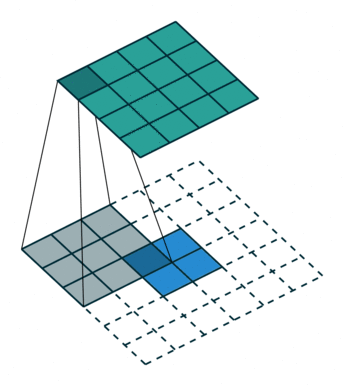![no_padding_no_strides_transposed.gif](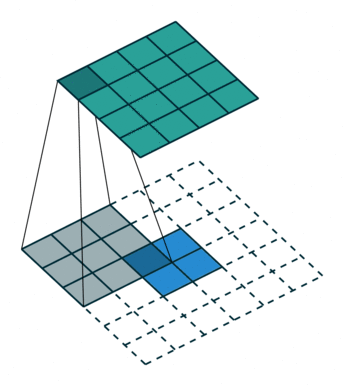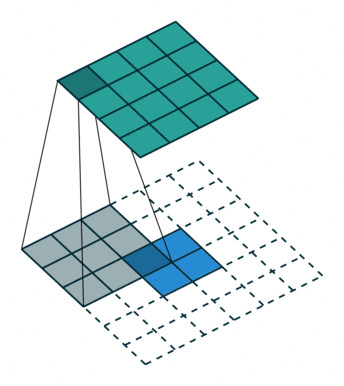))

## Coding

In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.1 MB/s eta 0:00:00


In [4]:
import os
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed =42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

## Model Setup

In [7]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, data_dir="./data",
               batch_size=BATCH_SIZE,
               num_workers=NUM_WORKERS):
    super().__init__()
    self.data_dir=data_dir
    self.batch_size=batch_size
    self.num_workers=num_workers

    # The normalization is done with the calculated mean and sd of the training set
    self.transform = v2.Compose([v2.ToTensor(),
                                v2.Normalize((0.1207,), (0.3081))])

    def prepare_data(self):
      MNIST(self.data_dir, train=True, download=True)
      MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # assign train/val datasets
        if stage == "fit" or stage is None:
          mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
          self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
          self.mnist_test = MNIST(self.data_path, train=False, transform=self.transform)

    def train_dataloader(self):
      return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    def val_dataloader(self):
      return DataLoader(self.mnist_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    def test_dataloader(self):
      return DataLoader(self.mnist_test, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [12]:
# Create Discriminator Class with output [0,1]

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    #Simple CNN
    self.layer_stack_1 = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    )

    self.layer_stack_2 = nn.Sequential(
        nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    )

    self.fc1 = nn.Linear(320, 50)
    self.classifier = nn.Linear(50,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_stack_1(x)
    x = self.layer_stack_2(x)

    x = torch.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.classifier(x)
    return torch.sigmoid(x)

In [13]:
# Test the model on a random input

tensor = torch.randn(28, 28).unsqueeze(0)
test_discriminator = Discriminator()

out = test_discriminator(tensor)
out

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


tensor([0.4991], grad_fn=<SigmoidBackward0>)

What is `nn.ConvTranspose2d()`

Key Parameters:
- in_channels
- out_channels
- kernel_size
- stride = 1
- padding = 0

Applies a 2d transposed convolution over an input image of serveral input planes. Can be understood as a de-convolution but doesn't compute an acutal inverse of the convolutions.
- Image take a smaller input and expanding to produce a larger output
- Used to upsample feature maps
- Pads input with zeros and sliding the filter over the input and performs convolution like operations which expand the dimension of the input

https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides_transposed.gif

<br>

Suppose you have 10 feature maps and wanted to output 3 feature maps. Then you apply 3 different weigth matrices (kernels) that produce the 3 feature maps.

This is separate from the spatial dimensions of each feature map, which is determined by the convolution parameters (stride, padding, kernel size). Note the two kernels are not the same.

In [ ]:
# Crate the Generator Class like real data [1, 28, 28]

class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.lin1 = nn.Linaer(latent_dim, 7*6*64) # [n, 256, 7, 7]
    self.ct1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2)
    self.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2)
    self.conv = nn.Conv2d(16, 1, kernel_size=7)
    self.relu = nn.ReLU()

  def forward(self, x):

    # Pass latent space input into linear layer and reshape
    x = self.lin1(x)
    x = self.relu(x)
    x = x.permute(2,1,0)

    # Upsample (transposed conv) 16x16 images with (64 feature maps)
    x = self.ct1(x)
    x = self.relu(x)

    # Upsample to 34x34 (16 feature maps)
    x = self.ct2(x)
    x = self.relu(x)

    # Apply convovlution to reduce dimension to 28x28
    return self.conv(x)



## Training